## IEEE-CIS Fraud Detection

In [ ]:
# https://www.kaggle.com/c/ieee-fraud-detection

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
df_train_transaction = pd.read_csv("E:/Python Stuff/ieee-fraud-detection/train_transaction.csv")
df_train_identity = pd.read_csv("E:/Python Stuff/ieee-fraud-detection/train_identity.csv")

Transaction Table:<br>
TransactionDT: timedelta from a given reference datetime (not an actual timestamp)<br>
TransactionAMT: transaction payment amount in USD<br>
ProductCD: product code, the product for each transaction<br>
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.<br>
addr: address<br>
dist: distance<br>
P_ and (R__) emaildomain: purchaser and recipient email domain<br>
C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.<br>
D1-D15: timedelta, such as days between previous transaction, etc.<br>
M1-M9: match, such as names on card and address, etc.<br>
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.<br>

Categorical Features:<br>
ProductCD<br>
card1 - card6<br>
addr1, addr2<br>
P_emaildomain<br>
R_emaildomain<br>
M1 - M9<br>

Identity Table:<br>
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)<br>

Categorical Features:<br>
DeviceType<br>
DeviceInfo<br>
id_12 - id_38

In [6]:
df_train = pd.merge(df_train_transaction,df_train_identity,how="outer")

In [7]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [8]:
X = df_train.drop(columns=["isFraud","TransactionID"])

In [9]:
# category feature columns
cat_col = ["ProductCD",'addr1','addr2', 'P_emaildomain','R_emaildomain',"DeviceType","DeviceInfo"]
for card_num in range(1,7):
    cat_col.append("card{}".format(card_num))
for M_num in range(1,10):
    cat_col.append("M{}".format(M_num))
for id_num in range(12,39):
    cat_col.append("id_{}".format(id_num))
print(cat_col)

['ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [10]:
# fillna for category feature columns
for col in cat_col:
    X[col].fillna("X",inplace=True)
    X[col] = X[col].astype(str)

In [11]:
# fillna for other columns
for col in (X.columns ^ cat_col):
    X[col].fillna(X[col].median(),inplace=True)

In [12]:
# label encoding for category feature columns
for col in cat_col:
    le = LabelEncoder() 
    X["{}_encoded".format(col)]= le.fit_transform(X[col]) 
X.drop(columns=cat_col, inplace=True)

In [13]:
X.head()

,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,ProductCD_encoded,addr1_encoded,addr2_encoded,P_emaildomain_encoded,R_emaildomain_encoded,DeviceType_encoded,DeviceInfo_encoded,card1_encoded,card2_encoded,card3_encoded,card4_encoded,card5_encoded,card6_encoded,M1_encoded,M2_encoded,M3_encoded,M4_encoded,M5_encoded,M6_encoded,M7_encoded,M8_encoded,M9_encoded,id_12_encoded,id_13_encoded,id_14_encoded,id_15_encoded,id_16_encoded,id_17_encoded,id_18_encoded,id_19_encoded,id_20_encoded,id_21_encoded,id_22_encoded,id_23_encoded,id_24_encoded,id_25_encoded,id_26_encoded,id_27_encoded,id_28_encoded,id_29_encoded,id_30_encoded,id_31_encoded,id_32_encoded,id_33_encoded,id_34_encoded,id_35_encoded,id_36_encoded,id_37_encoded,id_38_encoded
0,86400,68.5,19.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,0.0,0.0,37.875,0.666666,13.0,13.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [14]:
y = df_train["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
categorical_feature = ["{}_encoded".format(col) for col in cat_col]

In [16]:
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, categorical_feature=categorical_feature)
test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False, categorical_feature=categorical_feature)

In [23]:
params = {'objective':'binary', "metric":"auc", "learning_rate":0.001, "num_round":10000}

In [24]:
evaluation_results = {}
clf = lgb.train(train_set=train_data,
                 params=params,
                 valid_sets=[train_data, test_data], 
                 valid_names=['Train', 'Test'],
                 evals_result=evaluation_results,
                 verbose_eval=2000
                )

[LightGBM] [Info] Number of positive: 15435, number of negative: 427470
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43718
[LightGBM] [Info] Number of data points in the train set: 442905, number of used features: 430
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034849 -> initscore=-3.321246
[LightGBM] [Info] Start training from score -3.321246
[2000]	Train's auc: 0.933235	Test's auc: 0.920314
[4000]	Train's auc: 0.955589	Test's auc: 0.939598
[6000]	Train's auc: 0.965683	Test's auc: 0.947636
[8000]	Train's auc: 0.972307	Test's auc: 0.952999
[10000]	Train's auc: 0.977027	Test's auc: 0.956587


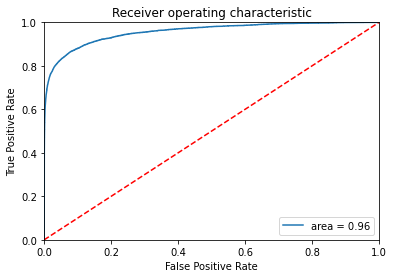

In [25]:
y_test_hat = clf.predict(X_test)
auroc = roc_auc_score(y_test, y_test_hat)
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat)
plt.figure()
plt.plot(fpr, tpr, label='area = %0.2f' % auroc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [26]:
cm = confusion_matrix(y_test, y_test_hat.round())
print(cm)

[[142208    199]
 [  2373   2855]]
